# Convert SnowMIP forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Col de Porte, France

Grassy meadow bordered by coniferous forest. Soils are 30% clay, 60% sand and 10% silt.

| Short name | cdp |
|:-----------|:----|
| Location | 45.30ºN, 5.77ºE |
| Elevation | 1325 m |
| Snow-free albedo | 0.2 |
| Simulation period | 1 October 1994 to 30 September 2014 |
| Temperature/humidity measurement height | 1.5 m |
| Wind measurement height | 10 m |
| Reference | Morin et al. (2012) |

In [4]:
site = 'cdp_30_60_min'
# site = 'cdp'
site_longname = 'Col de Porte, France'

year_start = '1994'
year_end = '2014'

lat = 45.30
lon = 5.77

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/cdp already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp/forcing already exist.


### Open original forcing file

In [5]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 175320)
Coordinates:
  * time     (time) datetime64[ns] 1MB 1994-10-01T01:00:00 ... 2014-10-01
Data variables:
    LWdown   (time) float32 701kB ...
    Psurf    (time) float32 701kB ...
    Qair     (time) float32 701kB ...
    Rainf    (time) float32 701kB ...
    Snowf    (time) float32 701kB ...
    SWdown   (time) float32 701kB ...
    Tair     (time) float32 701kB ...
    Wind     (time) float32 701kB ...

In [48]:
ds.time.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1048576,),
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/met_insitu_cdp_1994_2014.nc',
 'original_shape': (175320,),
 'dtype': dtype('float32'),
 'units': 'hours since 1900-01-01 00:00:00.0'}

In [4]:
# Check if there are leap years
ds.sel(time='2004-02')
# ds.sel(time='2016-02')

<xarray.Dataset> Size: 28kB
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2004-02-01 ... 2004-02-29T23:00:00
Data variables:
    LWdown   (time) float32 3kB ...
    Psurf    (time) float32 3kB ...
    Qair     (time) float32 3kB ...
    Rainf    (time) float32 3kB ...
    Snowf    (time) float32 3kB ...
    SWdown   (time) float32 3kB ...
    Tair     (time) float32 3kB ...
    Wind     (time) float32 3kB ...

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [5]:
ds_30min = ds.resample(time='30min').interpolate()
ds_30min

<xarray.Dataset> Size: 25MB
Dimensions:  (time: 350639)
Coordinates:
  * time     (time) datetime64[ns] 3MB 1994-10-01T01:00:00 ... 2014-10-01
Data variables:
    LWdown   (time) float64 3MB 337.8 337.7 337.6 337.4 ... 354.2 356.7 359.2
    Psurf    (time) float64 3MB 8.638e+04 8.638e+04 ... 8.638e+04 8.638e+04
    Qair     (time) float64 3MB 0.008458 0.008453 0.008449 ... 0.008684 0.008817
    Rainf    (time) float64 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Snowf    (time) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SWdown   (time) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Tair     (time) float64 3MB 284.1 284.1 284.0 283.9 ... 283.4 283.5 283.6
    Wind     (time) float64 3MB 0.916 0.866 0.816 0.7665 ... 0.4 0.6 0.8 1.0

## Check that after interpolation the cumulated precip (in mm/year) is reasonably conserved

In [6]:
ds.Snowf.sum()*3600*24/365

<xarray.DataArray 'Snowf' ()> Size: 8B
array(828.7918697)

In [7]:
ds_30min.Snowf.sum()*3600*24/365/2

<xarray.DataArray 'Snowf' ()> Size: 8B
array(828.79178784)

In [8]:
ds.Rainf.sum()*3600*24/365

<xarray.DataArray 'Rainf' ()> Size: 8B
array(1596.20361328)

In [9]:
ds_30min.Rainf.sum()*3600*24/365/2

<xarray.DataArray 'Rainf' ()> Size: 8B
array(1596.20347315)

### Slice file to full years (as CLASSIC expect only full years)
It is not required as long as you only use the full years in the job file

In [11]:
year_start_full = str(int(year_start) + 1)
year_end_full = str(int(year_end) - 1)

ds_subset = ds_30min.sel(time=slice(year_start_full, year_end_full))
ds_subset

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 333120)
Coordinates:
  * time     (time) datetime64[ns] 3MB 1995-01-01 ... 2013-12-31T23:30:00
Data variables:
    LWdown   (time) float64 3MB 308.3 308.8 309.2 309.2 ... 306.8 309.7 310.2
    Psurf    (time) float64 3MB 8.638e+04 8.638e+04 ... 8.638e+04 8.638e+04
    Qair     (time) float64 3MB 0.00427 0.004239 0.004208 ... 0.003917 0.003917
    Rainf    (time) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Snowf    (time) float64 3MB 0.0004167 0.0005764 ... 0.0009222 0.0004764
    SWdown   (time) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Tair     (time) float64 3MB 272.9 272.8 272.6 272.6 ... 271.9 272.0 272.0
    Wind     (time) float64 3MB 0.7 0.6 0.5 0.5 0.5 ... 1.65 1.5 1.55 1.6 1.5

In [12]:
ds_subset.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'.nc')

### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [15]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_{year_start_full}_{year_end_full}.nc {path_tmp}/met_insitu_{site}_30min_{year_start_full}_{year_end_full}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 2664960 values from 8 variables over 333120 timesteps [48.66s 855MB]


## Open the new file with absolute time

In [20]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_a.nc')
ds

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 333120)
Coordinates:
  * time     (time) float64 3MB 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
Data variables:
    LWdown   (time) float64 3MB ...
    Psurf    (time) float64 3MB ...
    Qair     (time) float64 3MB ...
    Rainf    (time) float64 3MB ...
    Snowf    (time) float64 3MB ...
    SWdown   (time) float64 3MB ...
    Tair     (time) float64 3MB ...
    Wind     (time) float64 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Apr 08 10:57:47 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [21]:
ds.time

<xarray.DataArray 'time' (time: 333120)> Size: 3MB
array([19950101.      , 19950101.020833, 19950101.041667, ..., 20131231.9375  ,
       20131231.958333, 20131231.979167])
Coordinates:
  * time     (time) float64 3MB 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [22]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 333120, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 3MB 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon      (lon) float64 8B 5.77
  * lat      (lat) float64 8B 45.3
Data variables:
    LWdown   (time, lat, lon) float64 3MB 308.3 308.8 309.2 ... 309.7 310.2
    Psurf    (time, lat, lon) float64 3MB 8.638e+04 8.638e+04 ... 8.638e+04
    Qair     (time, lat, lon) float64 3MB 0.00427 0.004239 ... 0.003917 0.003917
    Rainf    (time, lat, lon) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 3MB 0.0004167 0.0005764 ... 0.0004764
    SWdown   (time, lat, lon) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair     (time, lat, lon) float64 3MB 272.9 272.8 272.6 ... 272.0 272.0
    Wind     (time, lat, lon) float64 3MB 0.7 0.6 0.5 0.5 ... 1.5 1.55 1.6 1.5
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Apr 08 10:57:47 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

### Convert temperature to °C (<mark>required by CLASSIC</mark>)

In [23]:
with xr.set_options(keep_attrs=True):
    ds['Tair'] = ds['Tair'] - 273.15
    ds.Tair.attrs['units'] = '°C'
ds.Tair

<xarray.DataArray 'Tair' (time: 333120, lat: 1, lon: 1)> Size: 3MB
array([[[-0.2999939 ]],

       [[-0.4       ]],

       [[-0.5000061 ]],

       ...,

       [[-1.2999939 ]],

       [[-1.19998779]],

       [[-1.19998779]]])
Coordinates:
  * time     (time) float64 3MB 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon      (lon) float64 8B 5.77
  * lat      (lat) float64 8B 45.3
Attributes:
    long_name:  Near-surface air temperature
    units:      °C
    ALMA_name:  Tair
    CMIP_name:  ta

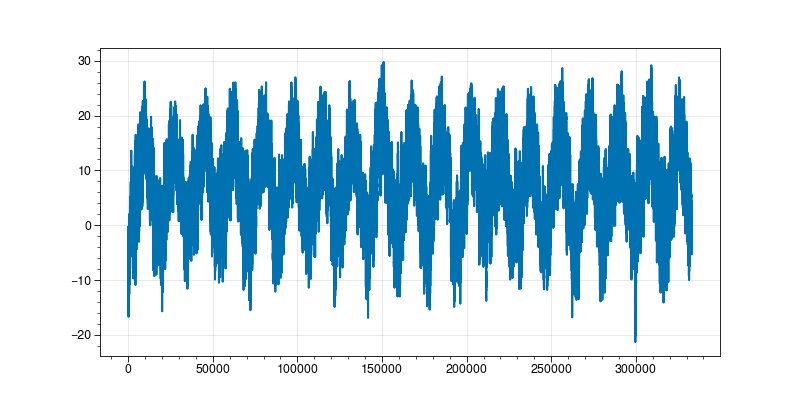

In [24]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

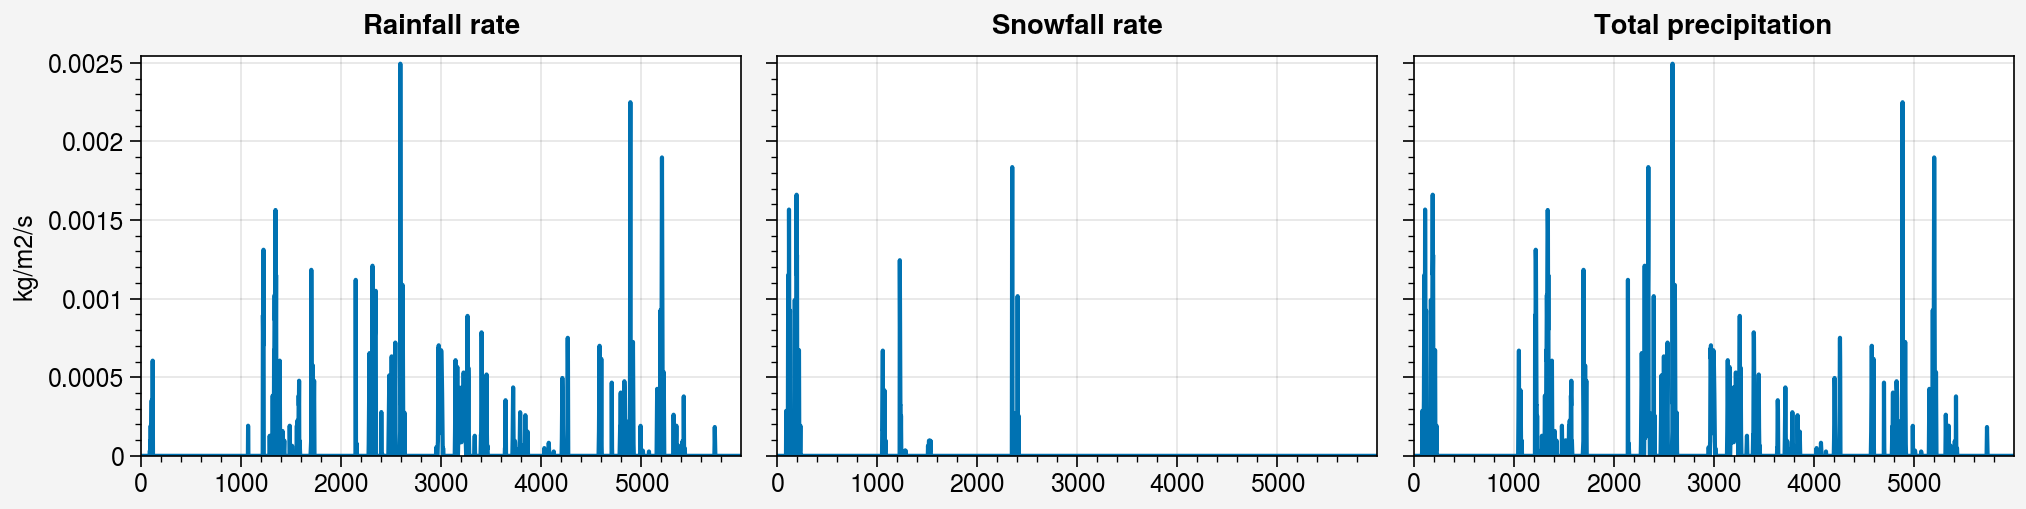

In [25]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 2000*2
i_end = 5000*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [26]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 333120, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 3MB 1.995e+07 1.995e+07 ... 2.013e+07 2.013e+07
  * lon        (lon) float64 8B 5.77
  * lat        (lat) float64 8B 45.3
Data variables:
    LWdown     (time, lat, lon) float64 3MB 308.3 308.8 309.2 ... 309.7 310.2
    Psurf      (time, lat, lon) float64 3MB 8.638e+04 8.638e+04 ... 8.638e+04
    Qair       (time, lat, lon) float64 3MB 0.00427 0.004239 ... 0.003917
    Rainf      (time, lat, lon) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 3MB 0.0004167 0.0005764 ... 0.0004764
    SWdown     (time, lat, lon) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair       (time, lat, lon) float64 3MB -0.3 -0.4 -0.5 ... -1.3 -1.2 -1.2
    Wind       (time, lat, lon) float64 3MB 0.7 0.6 0.5 0.5 ... 1.5 1.55 1.6 1.5
    TotPrecip  (time, lat, lon) float64 3MB 0.0004167 0.0005764 ... 0.0004764
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Apr 08 10:57:47 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## All the procedure may introduce negative precip values due to computing precision so replace them by 0

In [27]:
ds.Snowf.where(ds.Snowf < 0).sum()

<xarray.DataArray 'Snowf' ()> Size: 8B
array(-1.30104261e-18)

In [28]:
ds.Rainf.where(ds.Rainf < 0).sum()

<xarray.DataArray 'Rainf' ()> Size: 8B
array(-4.28598671e-18)

In [29]:
ds.TotPrecip.where(ds.TotPrecip < 0).sum()

<xarray.DataArray 'TotPrecip' ()> Size: 8B
array(-4.4655577e-18)

In [30]:
ds['Rainf'] = ds.Rainf.where(ds.Rainf > 0, other=0)
ds['Snowf'] = ds.Snowf.where(ds.Snowf > 0, other=0)
ds['TotPrecip'] = ds.TotPrecip.where(ds.TotPrecip > 0, other=0)

In [31]:
np.testing.assert_equal(ds.Rainf.where(ds.Rainf < 0).sum().values, 0)
np.testing.assert_equal(ds.Snowf.where(ds.Snowf < 0).sum().values, 0)
np.testing.assert_equal(ds.TotPrecip.where(ds.TotPrecip < 0).sum().values, 0)

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [35]:
path_out

'/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/cdp'

In [32]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_'+year_start_full+'_'+year_end_full+'_'+key+'.nc')

In [33]:
!ls {path_out}

met_insitu_cdp_1995_2013_LWdown.nc
met_insitu_cdp_1995_2013_Psurf.nc
met_insitu_cdp_1995_2013_Qair.nc
met_insitu_cdp_1995_2013_Rainf.nc
met_insitu_cdp_1995_2013_Snowf.nc
met_insitu_cdp_1995_2013_SWdown.nc
met_insitu_cdp_1995_2013_Tair.nc
met_insitu_cdp_1995_2013_TotPrecip.nc
met_insitu_cdp_1995_2013_Wind.nc
met_insitu_cdp_30min_1995_2013_LWdown.nc
met_insitu_cdp_30min_1995_2013_Psurf.nc
met_insitu_cdp_30min_1995_2013_Qair.nc
met_insitu_cdp_30min_1995_2013_Rainf.nc
met_insitu_cdp_30min_1995_2013_Snowf.nc
met_insitu_cdp_30min_1995_2013_SWdown.nc
met_insitu_cdp_30min_1995_2013_Tair.nc
met_insitu_cdp_30min_1995_2013_TotPrecip.nc
met_insitu_cdp_30min_1995_2013_Wind.nc
met_insitu_cdp_30min_ext_1994_2014_LWdown.nc
met_insitu_cdp_30min_ext_1994_2014_Psurf.nc
met_insitu_cdp_30min_ext_1994_2014_Qair.nc
met_insitu_cdp_30min_ext_1994_2014_Rainf.nc
met_insitu_cdp_30min_ext_1994_2014_Snowf.nc
met_insitu_cdp_30min_ext_1994_2014_SWdown.nc
met_insitu_cdp_30min_ext_1994_2014_Tair.nc
met_insitu_cdp_30min

In [34]:
!ls {path_out_CLASSIC}

met_insitu_cdp_1995_2013_LWdown.nc
met_insitu_cdp_1995_2013_Psurf.nc
met_insitu_cdp_1995_2013_Qair.nc
met_insitu_cdp_1995_2013_Rainf.nc
met_insitu_cdp_1995_2013_Snowf.nc
met_insitu_cdp_1995_2013_SWdown.nc
met_insitu_cdp_1995_2013_Tair.nc
met_insitu_cdp_1995_2013_TotPrecip.nc
met_insitu_cdp_1995_2013_Wind.nc
met_insitu_cdp_30min_1995_2013_LWdown.nc
met_insitu_cdp_30min_1995_2013_Psurf.nc
met_insitu_cdp_30min_1995_2013_Qair.nc
met_insitu_cdp_30min_1995_2013_Rainf.nc
met_insitu_cdp_30min_1995_2013_Snowf.nc
met_insitu_cdp_30min_1995_2013_SWdown.nc
met_insitu_cdp_30min_1995_2013_Tair.nc
met_insitu_cdp_30min_1995_2013_TotPrecip.nc
met_insitu_cdp_30min_1995_2013_Wind.nc
met_insitu_cdp_30min_ext_1994_2014_LWdown.nc
met_insitu_cdp_30min_ext_1994_2014_Psurf.nc
met_insitu_cdp_30min_ext_1994_2014_Qair.nc
met_insitu_cdp_30min_ext_1994_2014_Rainf.nc
met_insitu_cdp_30min_ext_1994_2014_Snowf.nc
met_insitu_cdp_30min_ext_1994_2014_SWdown.nc
met_insitu_cdp_30min_ext_1994_2014_Tair.nc
met_insitu_cdp_30min